In [2]:
import glob
from os.path import basename
import io
from twitter_dm.Tweet import Tweet, world_geocode_tweet
import re
from twitter_dm.TwitterUser import TwitterUser
from igraph import *
from collections import Counter
import numpy as np
import pickle
import ujson as json
from datetime import datetime
from twitter_dm.utility.tweet_utils import classify_language
import pandas as pd
import scipy
from collections import Counter
import seaborn as sns
from twitter_dm.utility.general_utils import tab_stringify_newline as tsn
import yaml
from twitter_dm.multiprocess.WorkerSimpleUserLookup import read_simple_user_info
from scipy.spatial.distance import pdist,squareform
from scipy.sparse.linalg import svds 
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances
from scipy import stats
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

%matplotlib inline

# Load in Reporter Data

In [2]:
# get basic Twitter information
basic_info = read_simple_user_info("data/basic_twitter_info.tsv")

In [3]:
# get basic muckrack information
writers_only = []
for f in glob.glob("data/writersHandles/*"):
    org = basename(f).replace("_Handles.csv","")
    dat = pd.read_csv(f,names=["muck_name","screen_name","muck_role","muck_url"])
    dat['muck_org'] = org.lower()
    writers_only.append(dat)
writer_data = pd.concat(writers_only,axis=0)

In [4]:
# merge
user_info = pd.merge(basic_info,writer_data,on='screen_name')
user_info = user_info.drop_duplicates("uid")
print user_info.shape, writer_data.shape, basic_info.shape

(1363, 23) (1445, 5) (1363, 19)


In [5]:
user_info.verified.value_counts()

True     866
False    497
Name: verified, dtype: int64

In [6]:
user_info = user_info[~user_info.muck_org.isin(['guardian','bbc','dailymail','jpost'])]
user_info = user_info[user_info.friends_count > 50]

In [7]:
Counter([x for y in user_info.muck_role for x in y.split()]).most_common()[:5]

[('Reporter', 481),
 ('Editor', 164),
 ('and', 159),
 ('Correspondent', 118),
 ('Writer', 106)]

In [8]:
user_info.muck_role.value_counts()[1:5]

Staff Writer              28
Columnist                 28
Political Reporter        21
Congressional Reporter    15
Name: muck_role, dtype: int64

In [9]:
of = open("data/user_ids.txt","w")
[of.write(x+"\n") for x in user_info.uid.tolist()]
of.close()

In [10]:
user_info.shape

(1123, 23)

# Combine with Conservative/Liberal Scales

In [11]:
# all muckrack outlets
# Can use to check for if we want more data 
# med_out = pd.read_csv("ALLmuckrack_mediaOutlets.csv")
# med_out = med_out[med_out['Media Type'].isin(["Newspaper","Online/Digital","Magazine"])]
# fb_cons_lib_scale = pd.read_csv("top500.csv")[['domain','avg_align']]
# pd.merge(fb_cons_lib_scale,med_out,left_on="domain",right_on="Website").sort_values("avg_align",ascending=False)[30:50]

In [13]:
# Organizations of interest to the present work
org_info = pd.read_csv("data/org_info.tsv",sep="\t")
org_info = org_info[~org_info.muckrack_slug.isnull()]
org_info = org_info[~org_info.muckrack_slug.isin(["slate","salon"])]

# Bakshy data
fb_cons_lib_scale = pd.read_csv("data/top500.csv")[['domain','avg_align']]
web_to_org = {}
for k, v in org_info.iterrows():
    for website in v['media_website'].split(","):
        web_to_org[website] = v['muckrack_slug']
fb_cons_lib_scale['Source'] = fb_cons_lib_scale.apply(lambda x: web_to_org.get(x['domain'],""),axis=1)
fb_cons_lib_scale = fb_cons_lib_scale[fb_cons_lib_scale.Source != ""].groupby("Source").avg_align.mean().reset_index()

In [14]:
set(org_info.muckrack_slug) - set(user_info.muck_org) 

{'bbc', 'dailymail', 'guardian', 'jpost'}

In [15]:
set(user_info.muck_org) - set(org_info.muckrack_slug) 

set()

In [16]:
# Merge in only FB scores, for now
user_info['muck_org']  = user_info.muck_org.str.lower()
user_info = pd.merge(user_info,org_info,left_on="muck_org",right_on="muckrack_slug")
print user_info.shape
user_info = pd.merge(user_info,fb_cons_lib_scale,left_on="muck_org",right_on="Source",how="left")
user_info.shape

(1123, 27)


(1123, 29)

# Read in Politician Data

In [3]:
leg_sm = yaml.load(open("data/legislators-social-media.yaml"))

In [4]:
tw_id_to_bio = pd.DataFrame([(x['id']['govtrack'],str(x['social']['twitter_id'])) 
                                for x in leg_sm if 'twitter_id' in x['social'] and 'govtrack' in x['id']],
                            columns=['ID','tw_id'])

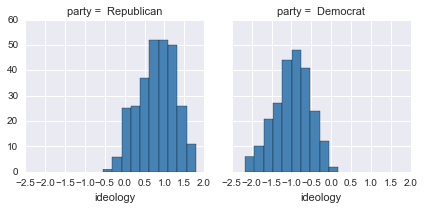

In [5]:
scores = pd.concat((pd.read_csv("data/sponsorshipanalysis_h.txt"),
                    pd.read_csv("data/sponsorshipanalysis_s.txt")))
scores = pd.merge(tw_id_to_bio,scores,on="ID")
scores['ID'] = scores.ID.astype(str)
scores.columns = [x.strip() for x in scores.columns]
scores['ideology'] = scale(scores.ideology)

g = sns.FacetGrid(scores[scores.party.isin([" Republican"," Democrat"])], col="party")
g.map(plt.hist, "ideology", color="steelblue")

In [7]:
scores.shape

(523, 11)

# Follower/Friend Networks

In [21]:
def get_friend_or_fol(data_dir,dir_file_name,reporter_uids,user_info):
    gone = 0
    full_map = defaultdict(list)
    reporter_map = defaultdict(list)
    all_res = Counter()
    for i,uid_df in user_info.iterrows():
        uid = str(uid_df.uid)
        fil = os.path.join(data_dir,uid_df[str(dir_file_name)])
        if os.path.exists(fil):
            all_d =  [x.strip() for x in open(fil)]
            full_map[uid] = all_d
            all_res.update(all_d)
            reporter_map[uid] = [x for x in all_d if x.strip() in reporter_uids]
        else:
            gone +=1 
    counts = pd.DataFrame(Counter([len(x) for x in reporter_map.values()]).most_common(),columns=['x','y'])
    medv = np.median(np.array([len(x) for x in reporter_map.values()]))
    r = scipy.stats.describe(np.array([len(x) for x in reporter_map.values()]))
    print tsn(["Missing:", gone, "Mean:",r.mean, "Median:", medv, "Variance:", r.variance],newline=False)
    #sns.lmplot('x','y',fr_counts, fit_reg=False)
    return reporter_map, full_map, all_res


In [22]:
reporter_uids = set(user_info.uid.tolist())

(_, 
 reporter_friend_map, 
 reporter_all_friends) = get_friend_or_fol("data/reporter_friends", 'uid',reporter_uids,user_info)


Missing:	0	Mean:	84.3517364203	Median:	65.0	Variance:	6190.77724074


In [24]:
# get basic Twitter information
heavypol_user_info = read_simple_user_info("data/heavy_pol_basic_twitter_info.tsv")
heavypol_user_info = heavypol_user_info[~heavypol_user_info.uid.isin(user_info.uid)]
heavypol_users = set(heavypol_user_info.uid)

(_, 
 heavypol_friend_map, 
 heavypol_all_friends) = get_friend_or_fol("data/heavy_user_friends", 'uid',heavypol_users,heavypol_user_info)

Missing:	0	Mean:	3.81151570702	Median:	1.0	Variance:	76.9481373774


In [25]:
print len(reporter_friend_map), len(reporter_all_friends),  len(reporter_uids)
print len(heavypol_friend_map), len(heavypol_all_friends),  len(heavypol_users)

1123 539045 1123
12001 3751076 12001


# Run SVD

In [26]:
def convertPPMI(mat):
    """
     Compute the PPMI values for a raw co-occurrence matrix.
     PPMI values will be written to mat and it will get overwritten.
     """    
    (nrows, ncols) = mat.shape
    print "no. of rows =", nrows
    print "no. of cols =", ncols
    colTotals = mat.sum(axis=0)
    rowTotals = mat.sum(axis=1).T
    N = np.sum(rowTotals)
    rowMat = np.ones((nrows, ncols), dtype=np.float)
    for i in range(nrows):
        rowMat[i,:] = 0 if rowTotals[i] == 0 else rowMat[i,:] * (1.0 / rowTotals[i])
    colMat = np.ones((nrows, ncols), dtype=np.float) 
    for j in range(ncols):
        colMat[:,j] = 0 if colTotals[j] == 0 else (1.0 / colTotals[j])
    P = N * mat * rowMat * colMat
    P = np.fmax(np.zeros((nrows,ncols), dtype=np.float64), np.log(P))
    return P

In [27]:
(len(user_info)+len(heavypol_user_info)) *.01

131.24

In [28]:
friend_df = pd.DataFrame(reporter_all_friends.most_common() + heavypol_all_friends.most_common(),columns=['x','y'])
friend_df = friend_df[(friend_df.y > ((len(user_info)+len(heavypol_user_info)) *.02)) |
                      (friend_df.x.isin(tw_id_to_bio.tw_id))]
all_interesting_friends = set(friend_df.x)


In [29]:
len(all_interesting_friends)

3051

In [30]:
friend_net = []
for reporter, friends in reporter_friend_map.iteritems():
    friend_net += [(reporter,elite,1) for elite in set(friends) & all_interesting_friends]

for heavypol_user, friends in heavypol_friend_map.iteritems():
    friend_net += [(heavypol_user,elite,1) for elite in set(friends) & all_interesting_friends]

friend_net = pd.DataFrame(friend_net)

In [31]:
field_to_user_count = friend_net.copy()
field_to_user_count.columns=["reporter_heavypol","elite","value"]

In [32]:
data_matrix = field_to_user_count.pivot("reporter_heavypol","elite","value")
data_matrix.fillna(0,inplace=True)

In [33]:
ppm = data_matrix
ppmi_matrix = convertPPMI(ppm.as_matrix())
#ppmi_matrix = data_matrix.as_matrix()

no. of rows = 12353
no. of cols = 3051


/Users/kennyjoseph/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log


# Run SVD


In [34]:
# Determine basic scores for reporters
studied_uids = set(user_info.uid.tolist() + heavypol_user_info.uid.tolist())
pol_follow_map = []
for fil in glob.glob("data/congress_followers/*"):
    u_name = basename(fil)
    followers = set([x.strip() for x in open(fil)])
    for u in followers & studied_uids:
        pol_follow_map.append((u,u_name))

In [35]:
all_user_info = pd.concat((user_info,heavypol_user_info),axis=0)

pol_follow = pd.DataFrame(pol_follow_map,columns=['reporter_id','tw_id'])
pol_follow = pd.merge(pol_follow,scores,on="tw_id")
pol_follow = pd.merge(pol_follow,all_user_info,left_on='reporter_id',right_on='uid')
pf = pd.merge(pol_follow.groupby("uid").ideology.mean().reset_index(),
              pol_follow.groupby("uid").size().reset_index(), on="uid")
pf.columns = ['uid','mean_ideology_following',"n_pol_follows"]

all_user_info = pd.merge(all_user_info,pf,on="uid",how='left')
all_user_info['n_pol_follows'] = all_user_info.n_pol_follows.fillna(0)


In [36]:
n_svd_dimensions = 5
U, s, V = svds(ppmi_matrix,k=n_svd_dimensions)

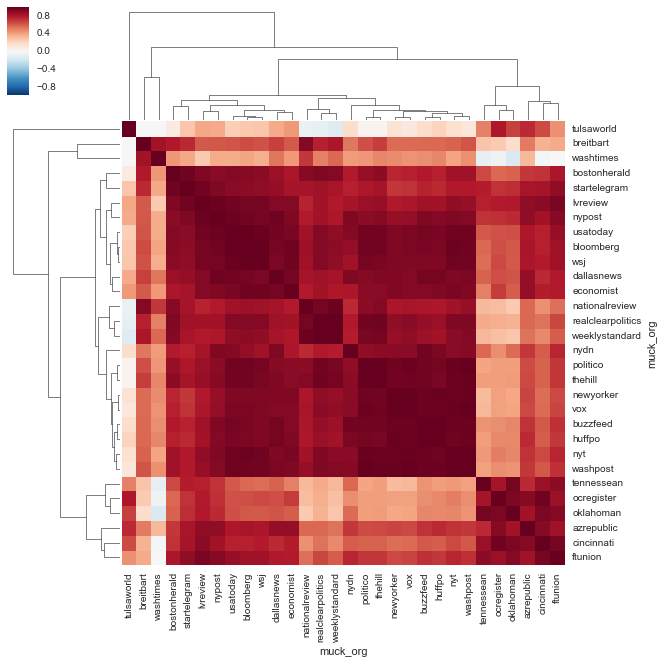

In [37]:
# put the SVD result into a dataframe
svd_result_U = pd.DataFrame(U,columns=['d'+str(i) for i in range(n_svd_dimensions)])
svd_result_U['source'] = data_matrix.reset_index().reporter_heavypol

svd_res_u = pd.merge(svd_result_U,all_user_info,left_on="source",right_on='uid')
#svd_res_u = pd.merge(svd_res_u,pol_follow.groupby("uid").ideology.mean().reset_index(), on="uid",how="left")
svd_res_u.to_csv("output/svdr.csv")

svd_result_V = pd.DataFrame(V.T,columns=['d'+str(i) for i in range(n_svd_dimensions)])
svd_result_V['source'] = data_matrix.columns
svd_res_v = pd.merge(svd_result_V,scores[['tw_id','ideology']],left_on='source',right_on='tw_id',how="left")
svd_res_v.to_csv("output/svdv.csv")

d= svd_res_u[['d'+str(i) for i in range(n_svd_dimensions)] + ['muck_org']].groupby("muck_org").mean()

d = pd.DataFrame(cosine_similarity( d[['d'+str(i) for i in range(n_svd_dimensions)]].as_matrix()),
                 columns=d.index)
d.index = d.columns

plt.figure(figsize=(7, 7))
g = sns.clustermap(d)
x = plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)